In [101]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [103]:
folder = '/Users/julianganzabal/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/'

## Cargo dataset

In [104]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [75]:
from keras.preprocessing import text, sequence

In [105]:
max_features = 10000
maxlen = 100

In [106]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

## Entreno tokenizer con el train set

In [107]:
list_sentences_train = X_train["comment_text"].fillna("CVxTz").values

In [108]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

In [109]:
list_sentences_valid = X_valid["comment_text"].fillna("CVxTz").values
list_sentences_test = test["comment_text"].fillna("CVxTz").values

## Obtengo test y train tokenizados y agrego padding

In [110]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_valid = tokenizer.texts_to_sequences(list_sentences_valid)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_tr = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_va = sequence.pad_sequences(list_tokenized_valid, maxlen=maxlen)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [111]:
X_tr.shape, X_va.shape, X_te.shape

((143613, 100), (15958, 100), (153164, 100))

In [112]:
longs = []
for fila in list_tokenized_train:
    longs.append(len(fila))

In [113]:
np.mean(longs), np.std(longs), np.max(longs)

(63.659320535049055, 94.262888352762459, 1399)

In [114]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras import initializers

In [115]:
output_size = y.shape[1]

In [116]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
#default_initializer = 'zeros'

In [124]:
model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=max_features, 
                    input_length=maxlen, 
                    embeddings_initializer='identity',
                    trainable=False
                   ))
model.add(Flatten())
model.add(Dense(output_size, 
               kernel_initializer=default_initializer
               ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 10000)        100000000 
_________________________________________________________________
flatten_15 (Flatten)         (None, 1000000)           0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 6000006   
Total params: 106,000,006
Trainable params: 6,000,006
Non-trainable params: 100,000,000
_________________________________________________________________


In [125]:
lr = 0.0001 
batch_size = 512
epochs = 4

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

In [119]:
model.evaluate(X_va, Y_valid)

15958/15958 [==============================] - 54s 3ms/step


[0.41916118398110797, 0.96386347607063882]

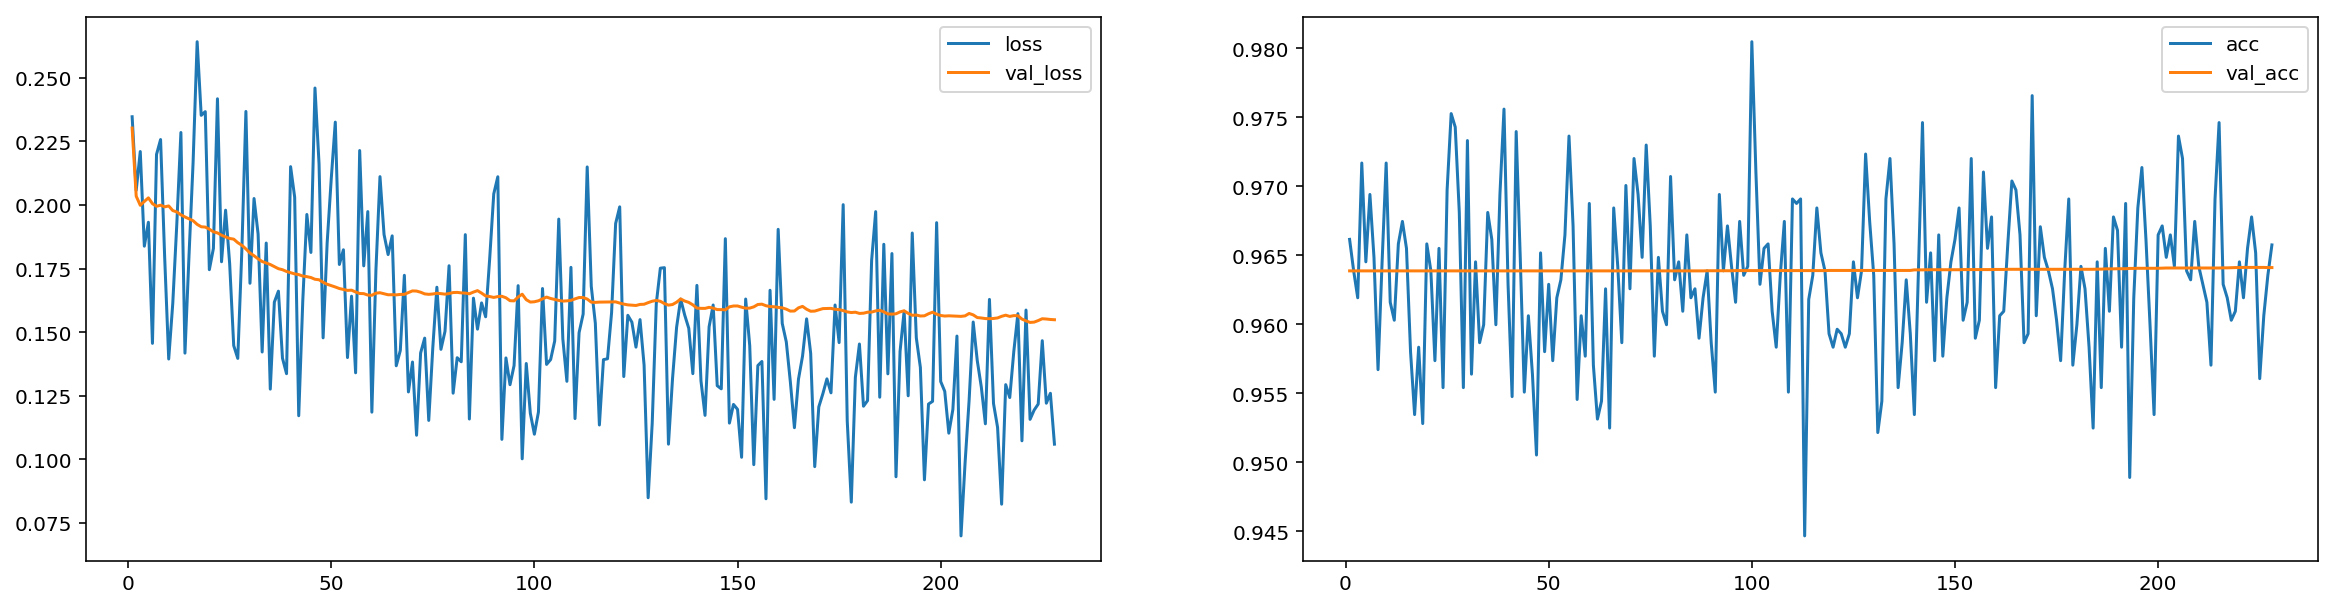


Epoch 00004: val_loss improved from 0.15931 to 0.15493, saving model to basic_model_best.hdf5


In [127]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=X_va, 
                         y_val_categorical=Y_valid)
history = model.fit(X_tr, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(X_va, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

In [128]:
pred_valid = model.predict(X_va, verbose = 1)
pred_train = model.predict(X_tr, verbose = 1)

143613/143613 [==============================] - 363s 3ms/step


In [129]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='micro'))
print(roc_auc_score(Y_valid, pred_valid, average='micro'))

0.929967806791
0.892085720098


0.826793548435
0.792394465644